# Thuật toán XGBoost

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

path_final = "/content/drive/MyDrive/LTSSUD"
import os

if (os.path.isdir(path_final) == True):
  %cd "/content/drive/MyDrive/LTSSUD"

!ls

Mounted at /content/drive
/content/drive/MyDrive/LTSSUD
Data_Preparation___Image_processing.ipynb  Proposal.gdoc
dataset					   results_base.pkl
Final_report.ipynb			   results_img_acc.pkl
handle_imb.ipynb			   results.pkl
lib_results.pkl				   sequence.ipynb
models					   train_data_128_full.npz
parallel.ipynb				   winequality-red.csv
parallel_v1.ipynb			   XGB_regression.ipynb


In [ ]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
from numba import jit

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute  import SimpleImputer
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 1. Gradient Boosting

- Ý tưởng cơ bản là Boosting sẽ tạo ra một loạt các model yếu, học bổ sung lẫn nhau. Nói cách khác, trong Boosting, các model sau sẽ cố gắng học để hạn chế lỗi lầm của các model trước.
- Các model sau sẽ dự đoán giá trị residual mà kết quả của model trước để lại với công thức:<br>
$$
residual = y - preds
$$
- Với kết quả trả về sẽ là list các model. Với các model nhỏ được xây dựng theo thuật toán của XGB gợi là XGB tree
- Các giá trị dự đoán sẽ đc tính theo công thức:<br>
$$ Predictions += Learningrate*Preds $$

## 2. XBG Tree classifier

***Các hàm log dưới đây đều là log bậc e***

Ta sẽ bắt đầu với hàm Loss function `Negative log-likelihood` của bài toán phân lớp trước:<br>
$$
(1) \sum L(y_i, p_i)= - \sum [y_ilog(p_i)+(1-y_i)log(1-p_i)]
$$
- $y_i$ là nhãn dưới dạng probability(p)
- $p_i$ là tỉ lệ dự đoán dưới dạng p  

Khác với bài toán hồi quy thì output của bài toán phân lớp nhị phân bị giới hạn trong đoạn từ 0 đến 1 nên để quy nó về bài toán hồi quy thông thường thì ta sẽ dùng đến $log(odds)$:
$$log(odds) = log(\frac p {1-p})$$
$$p = \frac {odds} {1 - odds}$$
- $p$ là tỉ lệ từ 0 đến 1

Ta chuyển công thức (1) sang dạng $log(odds)$ ta được:
$$
(2)\sum = L(y_i, log(odds)) = - \sum[y_ilog(odds) - log(1 + e^{log(odds)})]
$$

Dựa vào khai triển bậc 2 ta có công thức sau:
$$
  L(y_i, p_i + O) \approx L(y_i, p_i) + [ \frac {d} {d p_i} L(y_i, p_i)]O + [ \frac {d^2} {d^2 p_i} L(y_i, p_i)]O^2
$$
- Trong đó O là giá trị ta đang quan sát
- Đạo hàm bậc 1 và 2 của $L(y_i, p_i)$ lần lượt được gọi là gradient(g) và hessian(h)
<br>Khi đạo hàm của công thức trên theo O ta được:
 $$
 O = \frac {-g}{h+\lambda}
 $$

$$
g = L'(y_i, log(odds)) = -y_i + \frac{e^{log(odds)}}{1 + e^{log(odds)}} = -(y_i - p_i)
$$
$$
h = L''(y_i, log(odds)) = \frac{e^{log(odds)}}{1 + e^{log(odds)}}*\frac{1}{1 + e^{log(odds)}} = p_i(1 - p_i)
$$

## Classification

In [ ]:
class XGBoostTree:
    def __init__(self, max_depth=3, min_samples_split=1, min_impurity=1e-7, gamma = 0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.gamma = gamma
        self.tree = {}
        self.fbs_t = [0,0]

    #split_data chia dữ liệu ra làm đôi tại split value
    def split_data(self, X, feature_index, split_value):
        left_indices = X[:, feature_index] <= split_value
        right_indices = X[:, feature_index] > split_value
        return left_indices, right_indices

    #Tính tất cả giá trị similarity của mảng input
    def similarity(self, y_true, p, i = 2):
        numerator = np.sum(y_true)**i
        denominator = np.sum(p * (1 - p)) + self.min_impurity
        return numerator / denominator

    #Tìm giá trị split có gain cao nhất
    #Đây là hàm được nhóm tiến hành cài đặt song song chính vì nó tốn nhiều thời gian để chạy nhất
    #Bên phiên bản tuần tự thì hàm này xử dụng 2 vòng lặp để tìm ra gain cũng như là gian lớn nhất
    #Phiên bản tuần tự khác ở chỗ các kích thước mảng feature qua n vòng lặp (n là số feature) không bằng nhau. Bởi vì nó lấy np.unique() của mảng này
    def find_best_split(self, X, y, probs):
        best_gain = -np.inf
        best_split_feature = None
        best_split_value = None

        num_samples, num_features = X.shape

        for feature_index in range(num_features): #Vòng lặp duyệt qua từng feature
            feature_values = X[:, feature_index]
            unique_values = np.unique(feature_values)
            split_values = np.zeros(len(unique_values)-1)
            for i in range(len(split_values)): #Tính giá trị mean giữa 2 phần tử cạnh nhau trong mảng unique_values
                split_values[i] = (unique_values[i]+unique_values[i+1])/2

            for value in split_values:
                left_indices, right_indices = self.split_data(X, feature_index, value)
                if len(left_indices) < self.min_samples_split or len(right_indices) < self.min_samples_split:
                    continue

                y_left = y[left_indices]
                y_right = y[right_indices]
                p_left = probs[left_indices]
                p_right = probs[right_indices]

                gain = self.similarity(y_left, p_left) + self.similarity(y_right, p_right) - self.similarity(y, probs) #Tính gain

                if gain > best_gain:
                    best_gain = gain
                    best_split_feature = feature_index
                    best_split_value = value
        if(best_gain - self.gamma < 0):
            best_split_feature = None
            best_split_value = None

        return best_split_feature, best_split_value

    #Tạo node lá
    def create_leaf_node(self, y, probs):
        return self.similarity(y, probs, 1)

    #Dựng cây
    def build_tree(self, X, y, probs, depth=0):
        if depth >= self.max_depth or len(X) <= self.min_samples_split:
            return self.create_leaf_node(y, probs)

        start = time.time()
        split_feature, split_value = self.find_best_split(X, y, probs)
        end = time.time()
        self.fbs_t[0] += 1
        self.fbs_t[1] += (end - start)

        if split_feature is None:
            return self.create_leaf_node(y, probs)

        left_indices, right_indices = self.split_data(X, split_feature, split_value)
        left_child = self.build_tree(X[left_indices], y[left_indices], probs[left_indices], depth + 1)
        right_child = self.build_tree(X[right_indices], y[right_indices], probs[right_indices], depth + 1)

        self.tree = {
            'split_feature': split_feature,
            'split_value': split_value,
            'left_child': left_child,
            'right_child': right_child
        }

        return self.tree

    def fit(self, X, y, probs):
        self.tree = self.build_tree(X, y, probs)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    #Truy suất cây được tạo để dự đoán giá trị
    def _traverse_tree(self, x, node):
        if isinstance(node, dict):
            split_feature = node['split_feature']
            split_value = node['split_value']
            if x[split_feature] <= split_value:
                return self._traverse_tree(x, node['left_child'])
            else:
                return self._traverse_tree(x, node['right_child'])
        else:
            return node

In [ ]:
#Loss function
def n_log_likelihood(y_true, y_pred):
    return -np.sum(y_true*np.log(y_pred)+ (1 - y_true)*np.log(1 - y_pred))

#Chuyển sang log(odds). Hàm này được nhóm tiến hành song song hóa ở trên
def converter(p):
        return np.log(p/(1-p)).astype(np.float64)

#Tính giá trị sai lệch. Hàm này được nhóm tiến hành song song hóa ở trên
@jit(nopython=True)
def residuals(y_true, y_pred):
    return (y_true - y_pred).astype(np.float64)

#Trả về đoạn [0,1] giống sigmoid (chỉ để thử nghiệm)
@jit(nopython=True)
def softmax(z):
    return np.exp(z)/(np.sum(np.exp(z), axis = 0))

def probability(y):
    p = np.sum(y == 1)/np.sum(y != 1)
    p = p/(1+p)
    ans = np.copy(y).astype(np.float64)
    ans[y == 1] = p
    ans[y != 1] = 1-p
    return ans

#Tạo cây dự đoán từ các sai lệch
def build_weak_learner(X, y, probs, min_impurity, gamma):
    model = XGBoostTree(min_impurity = min_impurity, gamma = gamma)
    model.fit(X, y, probs)
    return model

# Tạo XGBoost model
class XGBoostModel:
    def __init__(self, n_estimators, learning_rate, min_impurity = 1e-7, gamma = 0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.initial_prediction = 0
        self.min = None
        self.max = None
        self.min_impurity = min_impurity
        self.gamma = gamma
        self.models = []
        self.fbs_t = [0,0]
        self.con_t = [0,0]
        self.res_t = [0,0]
        self.ca_t = [0, 0]
        self.ca_exp = [0, 0]

    def fit(self, X, y):
        data = X
        self.min = np.min(y)
        self.max = np.max(y)

        classes, counts = np.unique(y, return_counts=True)
        self.initial_prediction = 0.5
        predictions = np.full(len(y), self.initial_prediction, dtype =np.float64)
        # Vòng lặp build tree model nơi mà model sau xử dụng kết quả dự đoán được của model trước đó
        for _ in range(self.n_estimators):
            probs = np.copy(predictions)
            start = time.time()
            residual = residuals(y, predictions)
            end = time.time()
            self.res_t[0] += 1
            self.res_t[1] += (end - start)

            model = build_weak_learner(data, residual, probs, self.min_impurity, self.gamma)
            self.fbs_t[0] += model.fbs_t[0]
            self.fbs_t[1] += model.fbs_t[1]

            #Cập nhật dự đoán
            start = time.time()
            log_odds = converter(predictions)
            end = time.time()
            self.con_t[0] += 1
            self.con_t[1] += (end - start)

            start = time.time()
            t = log_odds + self.learning_rate * model.predict(data)
            end = time.time()
            self.ca_t[0] += 1
            self.ca_t[1] += (end - start)

            start = time.time()
            predictions = np.around(np.exp(t) / (1 + np.exp(t)), decimals = 14)
            end = time.time()
            self.ca_exp[0] += 1
            self.ca_exp[1] += (end - start)

            # thêm model này vào chuỗi model từ đó hàm loss sẽ dân được cải thiên qua từng lần lặp
            self.models.append(model)

    def predict_proba(self, X):
        #Dự đoán khả năng nhãn là 1
        predictions = np.full(len(X),self.initial_prediction)
        for model in self.models:
            t = np.log(predictions/(1-predictions)) + self.learning_rate * model.predict(X)
            predictions = np.around(np.exp(t) / (1 + np.exp(t)), decimals = 14)

        return predictions

    def predict(self,X):
        return (self.predict_proba(X) > self.initial_prediction).astype(int)

## 1. Binary Classification

### Wine dataset

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dat = pd.read_csv('winequality-red.csv')
dat['quality'] = pd.cut(dat['quality'], bins=[2, 5, 8], right=True, labels=False)+1
y = dat['quality']= le.fit_transform(dat['quality'])
X = dat.drop(['quality'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state = 0)
train_X.fillna(0, inplace = True)
test_X.fillna(0, inplace = True)
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

In [ ]:
train_X.shape

(1199, 11)

In [ ]:
np.mean(train_y)

0.5337781484570475

In [ ]:
# Tạo và train XGBoost model
xgb_model = XGBoostModel(n_estimators=100, learning_rate=0.3, min_impurity = 0, gamma = 0)
start = time.time()
xgb_model.fit(train_X, train_y)
end = time.time()

In [ ]:
y_pred = xgb_model.predict(test_X)

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy_score : " + str(accuracy_score(test_y, y_pred)))

accuracy_score : 0.78


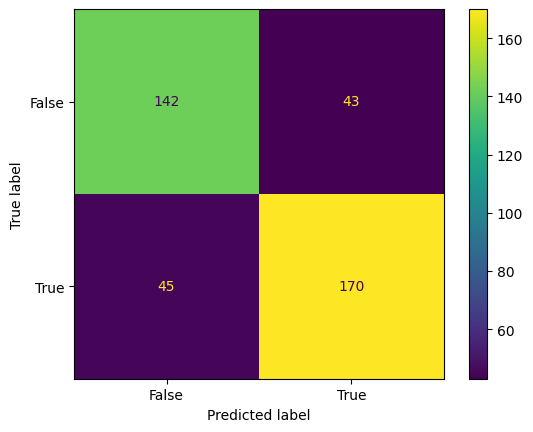

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test_y, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
print("Total time: " + str(end-start))

Total time: 39.36565375328064


In [ ]:
print("find_best_split total: " + str(xgb_model.fbs_t[0]) + ' in ' + str(xgb_model.fbs_t[1]) + 's')
print("residuals total: " + str(xgb_model.res_t[0]) + ' in ' + str(xgb_model.res_t[1]) + 's')
print("converter total: " + str(xgb_model.con_t[0]) + ' in ' + str(xgb_model.con_t[1]) + 's')

find_best_split total: 684 in 38.03931379318237s
residuals total: 100 in 1.0100650787353516s
converter total: 100 in 0.0062334537506103516s


## 2. Multi-Classification

In [ ]:
train = np.load('train_data_128_full.npz',allow_pickle=True)
test = np.load('dataset/test_data_128_full.npz',allow_pickle=True)
train_X = train['data']
train_y = train['label'].astype(int)
train_p = train['plant'].astype(int)
train_X = train_X[train['plant'] == 0]
train_y = train_y[train['plant'] == 0]
test_X = test['data']
test_y = test['label']
test_p = test['plant']
test_X = test_X[test['plant'] == 0]
test_y = test_y[test['plant'] == 0]

In [ ]:
print(train_X.shape)

(4108, 532)


In [ ]:
classes, counts = np.unique(train_y, return_counts=True)
models = []
preds = []
total_time = 0
for c in tqdm(classes):
  y_t = (train_y == c)
  t = XGBoostModel(n_estimators=10, learning_rate=0.4, min_impurity = 0, gamma = 0)
  start = time.time()
  t.fit(train_X,y_t)
  end = time.time()
  total_time += (end - start)
  models.append(t)
  preds.append(models[c].predict_proba(test_X))
pred = np.argmax(preds, axis=0)

100%|██████████| 4/4 [1:06:47<00:00, 1002.00s/it]


In [ ]:
print("accuracy_score : " + str(accuracy_score(test_y, pred)))

accuracy_score : 0.8911671924290221


In [ ]:
print("Total time: " + str(total_time))

Total time: 4007.9183537960052


In [ ]:
print("find_best_split total: " + str(sum([models[i].fbs_t[0] for i in classes])) + ' in ' + str(sum([models[i].fbs_t[1] for i in classes])) + 's')
print("residuals total: " + str(sum([models[i].res_t[0] for i in classes])) + ' in ' + str(sum([models[i].res_t[1] for i in classes])) + 's')
print("converter total: " + str(sum([models[i].con_t[0] for i in classes])) + ' in ' + str(sum([models[i].con_t[1] for i in classes])) + 's')

find_best_split total: 277 in 4006.4796557426453s
residuals total: 40 in 0.3780684471130371s
converter total: 40 in 0.004176616668701172s
